# Implementação do modelo BERT

- Implementação como possível agregação de novo modelo de vetorização: É uma possibilidade, tendo em vista que o modelo é alta escalabilidade e que é muito utilizado no mercado. No entanto, seu nível de complexidade é muito alto, e com a utilização da rede neural, dentro do modelo pré treinado acaba limitando demais as possibilidades de entrada.


## Instalação e preparação dos dados

In [5]:
import numpy as np
import pandas as pd
import csv
import nltk
import spacy
import re,string, unicodedata
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.graph_objects as go
import wordcloud
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
from collections import Counter
from textblob import TextBlob
from textblob import Word
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from plotly.subplots import make_subplots
from bs4 import BeautifulSoup
import ssl

In [6]:
df_lemma = pd.read_csv('lematizacao.csv')
df_lemma

ParserError: ignored

In [ ]:
import nltk 
nltk.download('stopwords')
nltk.download ('punkt')
nltk.download('wordnet')

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer

# carregamento do tokenizador do modelo prétreinado
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

# agreganado a tokenização mais uma vez na coluna
df_lemma['tokens'] = df_lemma['tokens'].apply(lambda x: tokenizer.tokenize(x))

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode sentiments
label_encoder = LabelEncoder()
df_lemma['sentimento_3'] = label_encoder.fit_transform(df_lemma['sentimento'])

In [ ]:
train_tokens = df_lemma['tokens']
train_tokens

## Definição das funções e variáveis a serem utilizadas

Parte de extração dos IDs nos tokens de entrada (input_ids), as máscaras de atenção (attention_mask) e inputs. Além disso, os rótulos de sentimento da coluna 'sentimento_3' do DataFrame df_lemma são convertidos em tensores usando torch.tensor e armazenados em labels.

In [ ]:
# biblioteca torch, que é usada para operações com tensores e trabalhar com redes neurais.
import torch

# definição do comprimento máximo da sequência para os tokens de entrada.
max_seq_length = 128

#  junção dos tokens em uma única string para cada linha
token_list = df_lemma['tokens'].apply(lambda x: ' '.join(x)).tolist()

# Tokenize and convert to input tensors
inputs = tokenizer.batch_encode_plus(
    token_list,
    max_length=max_seq_length,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
labels = torch.tensor(df_lemma['sentimento_3'].tolist())

In [ ]:
from transformers import BertModel, BertTokenizer

model = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# definição do número de classes para classificação.
num_classes = 3

# divisão do conjunto de dados em subconjuntos de treinamento e teste
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, test_size=0.2, random_state=42)
train_masks, test_masks, _, _ = train_test_split(attention_mask, labels, test_size=0.2, random_state=42)

# Tamanho do subconjunto
# OBS: colocamos pouco, por termos de otimizar a correção e entendimento

subset_size = 1000

train_inputs_subset = train_inputs[:subset_size]
train_labels_subset = train_labels[:subset_size]
train_masks_subset = train_masks[:subset_size]

# Definição do otimizador e a loss function
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Create DataLoader for efficient batch processing

# Essas linhas criam um objeto TensorDataset contendo os dados de treinamento, 
# composto pelos subconjuntos de entrada, máscaras de atenção e rótulos de treinamento.
# Em seguida, ele cria um DataLoader que permite o processamento eficiente em lotes (batches) 
# dos dados de treinamento, definindo o tamanho do lote como 16 e embaralhando os dados.

train_dataset = TensorDataset(train_inputs_subset, train_masks_subset, train_labels_subset)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Modify the model architecture to match the number of classes
model.classifier = nn.Linear(model.config.hidden_size, num_classes)

# Loop para treinamento 
# Epoch -> número de vezes que o modelo passará por todo o conjunto de treinamento.
# # OBS: colocamos poucas epochs, por termos de otimizar a correção e entendimento

num_epochs = 3

# O modelo é colocado no modo de treinamento com model.train(). 
# Em seguida, para cada época, o loop itera sobre os lotes de dados de treinamento obtidos do train_dataloader. 
# Os tensores de entrada, máscaras de atenção e rótulos são extraídos do lote. 
# O gradiente do otimizador é zerado com optimizer.zero_grad(). 
# Em seguida, o modelo é chamado com os tensores de entrada e máscaras de atenção e as saídas são calculadas. 
# Os logits (saída antes da aplicação da função de ativação) são obtidos a partir das saídas.

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in train_dataloader:
        inputs, masks, labels_batch = batch

        optimizer.zero_grad()

        outputs = model(inputs.to(device), attention_mask=masks.to(device))
        logits = outputs.last_hidden_state

        # o loss foi comentado para otimizar o tempo de carregamento do código

        # labels_onehot = torch.zeros(labels_batch.size(0), num_classes).to(device)
        # labels_onehot.scatter_(1, labels_batch.unsqueeze(1), 1)

    #     loss = criterion(logits, labels_batch.to(device))
    #     loss.backward()
    #     optimizer.step()

    #     running_loss += loss.item()

    # epoch_loss = running_loss / len(train_dataloader)

    #Impressão das epochs
    print(f'Epoch {epoch+1}/{num_epochs}')

#### Abaixo segue as implementações anteriores as quais tivemos os melhores resultados (não estão funcionando, pois estão subindo com erro)

In [ ]:
# import torch.optim as optim
# import torch.nn as nn
# from sklearn.model_selection import train_test_split
# from torch.utils.data import DataLoader, TensorDataset

# # Split the dataset into training and testing subsets
# train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, test_size=0.2, random_state=42)
# train_masks, test_masks, _, _ = train_test_split(attention_mask, labels, test_size=0.2, random_state=42)

# # Define the smaller subset size for faster training
# subset_size = 1000

# # Create smaller subsets of the training data
# train_inputs_subset = train_inputs[:subset_size]
# train_labels_subset = train_labels[:subset_size]
# train_masks_subset = train_masks[:subset_size]

# # Define the optimizer and loss function
# optimizer = optim.AdamW(model.parameters(), lr=2e-5)
# criterion = nn.CrossEntropyLoss()

# # Create DataLoader for efficient batch processing
# train_dataset = TensorDataset(train_inputs_subset, train_masks_subset, train_labels_subset)
# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# # Training loop
# num_epochs = 3

# num_classes = len(torch.unique(train_labels))

# model.train()
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for batch in train_dataloader:
#         inputs, masks, labels_batch = batch

#         optimizer.zero_grad()

#         outputs = model(inputs.to(device), attention_mask=masks.to(device))
#         logits = outputs.last_hidden_state

#         labels_onehot = torch.zeros(labels_batch.size(0), num_classes).to(device)
#         labels_onehot.scatter_(1, labels_batch.unsqueeze(1), 1)

# # # Calculate the loss
# #         loss = criterion(logits, labels_onehot)

# #         # loss = criterion(logits, labels_batch.to(device))
# #         loss.backward()
# #         optimizer.step()

# #         running_loss += loss.item()

# #     epoch_loss = running_loss / len(train_dataloader)
#     print(f'Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f}')

In [ ]:
# model.eval()
# batch_size = 16
# predictions = []

# with torch.no_grad():
#     for i in range(0, len(test_inputs), batch_size):
#         inputs = test_inputs[i:i+batch_size].to(device)
#         masks = test_masks[i:i+batch_size].to(device)

#         outputs = model(inputs, attention_mask=masks)
#         logits = outputs.last_hidden_state

#         _, predicted_labels = torch.max(logits, dim=1)
#         predictions.extend(predicted_labels.cpu().numpy())

# # Convert the predictions array to a 1-dimensional array
# predictions = np.array(predictions)

# # Convert the predictions to their original labels using the label_encoder
# predictions = label_encoder.inverse_transform(predictions)
# actual_labels = label_encoder.inverse_transform(test_labels)

# # Evaluate the performance using appropriate metrics
# print(classification_report(actual_labels, predictions))

## Testes das funções e processamentos/demonstrações

Na etapa de avaliação do modelo há o processamentos dos tensores, a máscara de atenção, tudo isso a partir dos subconjuntos separados anteriormente.


### Exemplos de testes de funções (seguindo o barema)

In [ ]:
## Exemplo de funções que poderiam ser implementadas;
# Devidos aos testes e complexidade não utilizamos em todo o contexto
# adicionamos exemplos para demonstrar como implementaríamos caso houvesse a necessidade

# Função para transformar uma lista 2D em um array 1D
# def flatten_list(lst):
#     return [item for sublist in lst for item in sublist]

# Função para avaliar o desempenho do modelo
# def evaluate_model(model, test_inputs, test_masks, label_encoder):
#     model.eval()
#     batch_size = 16
#     predictions = []
# with torch.no_grad():
#         for i in range(0, len(test_inputs), batch_size):
#             inputs = test_inputs[i:i+batch_size].to(device)
#             masks = test_masks[i:i+batch_size].to(device)

#             outputs = model(inputs, attention_mask=masks)
#             logits = outputs.last_hidden_state

#             _, predicted_labels = torch.max(logits, dim=1)
#             predictions.extend(predicted_labels.cpu().numpy())

#     predictions_flat = np.argmax(predictions, axis=1)
#     predictions_labels = label_encoder.inverse_transform(predictions_flat)
#     actual_labels = label_encoder.inverse_transform(test_labels.flatten())

#     all_labels = label_encoder.classes_

#     aligned_actual_labels = np.intersect1d(actual_labels, all_labels)
#     aligned_predictions_labels = np.intersect1d(predictions_labels, all_labels)

#     return aligned_actual_labels, aligned_predictions_labels, all_labels

In [ ]:
# Evaluation - que deu overfitting
model.eval()
batch_size = 16
predictions = []

# Essas linhas realizam a avaliação do modelo. 
# O loop é iterado para percorrer os dados de teste em lotes de tamanho "batch_size". 
# Os tensores de entrada e máscaras de atenção são obtidos para o lote atual e transferidos para o "device" de processamento. 
# O modelo é chamado com esses tensores e as saídas são calculadas. 
# Os logits são obtidos das saídas e as previsões são feitas selecionando a classe com o valor máximo dos logits usando torch.max. 
# As previsões são estendidas à lista predictions.

with torch.no_grad():
    for i in range(0, len(test_inputs), batch_size):
        inputs = test_inputs[i:i+batch_size].to(device)
        masks = test_masks[i:i+batch_size].to(device)

        outputs = model(inputs, attention_mask=masks)
        logits = outputs.last_hidden_state

        _, predicted_labels = torch.max(logits, dim=1)
        predictions.extend(predicted_labels.cpu().numpy())

# Convertendo a lista de predições para "1-dimensional array"
predictions_flat = np.argmax(predictions, axis=1)

# Convertendo as predições para seu original label usando o label_encoder
predictions_labels = label_encoder.inverse_transform(labels)
actual_labels = label_encoder.inverse_transform(test_labels.flatten())

# Conjunto completo de etiquetas disponíveis a partir do objeto label_encoder
all_labels = label_encoder.classes_

# as etiquetas reais e as etiquetas de previsão que estão presentes tanto nas etiquetas reais quanto nas etiquetas completas. 
# Isso garante que apenas as etiquetas relevantes sejam consideradas para a avaliação.
aligned_actual_labels = np.intersect1d(actual_labels, all_labels)
aligned_predictions_labels = np.intersect1d(predictions_labels, all_labels)

# o relatório de classificação usando as etiquetas reais, as etiquetas de previsão e todas as etiquetas possíveis. 
# O relatório de classificação contém métricas como precisão, recall, F1-score e suporte para cada classe.

from sklearn.metrics import classification_report

print(classification_report(aligned_actual_labels, aligned_predictions_labels, labels=all_labels))

## Gerando CSV das mascaras e inputs

In [ ]:
# Caminho para o arquivo CSV de saída
caminho_arquivo_csv = "inputs_BERT.csv"

# Escrever os dados no arquivo CSV
with open(caminho_arquivo_csv, mode='w', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv, delimiter=',')
    writer.writerow(["Inputs - BERT"])  # Escreve o cabeçalho
    writer.writerows(inputs_ids)  # Escreve os dados

print("Arquivo CSV gerado com sucesso!")

In [ ]:
# Caminho para o arquivo CSV de saída
caminho_arquivo_csv_mascara = "mascara_BERT.csv"

# Escrever os dados no arquivo CSV
with open(caminho_arquivo_csv_mascara, mode='w', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv, delimiter=',')
    writer.writerow(["Mascaras - BERT"])  # Escreve o cabeçalho
    writer.writerows(attention_mask)  # Escreve os dados

print("Arquivo CSV gerado com sucesso!")

## Resultados e Comparações nas implementação que fizemos

### O resultado atual do modelo, apresenta overfitting, e necessita de refatoração com base na parte de avaliação e aumento dos dados de teste e epochs.

### No entanto, em termos de teste e comparando com os outros métodos de vetorização e algoritmos, sua complexidade é nivelada apenas com o Elmo. E isto dificultou nossa implementação do modelo no geral. No entanto, após validação com o cliente, pudemos inferir que o modelo BERT é o mais escalável.

### Na comparação entre os modelos, tendo em vista os melhores resultados com Naive Bayes, Regressão Logística (todos os modelos foram testados em ambos algoritmos, exceto o BERT e ELMo) e Rede Neural (BERT e ELMo), fizemos a priorização da métrica "Recall", como anteriormente definido. 

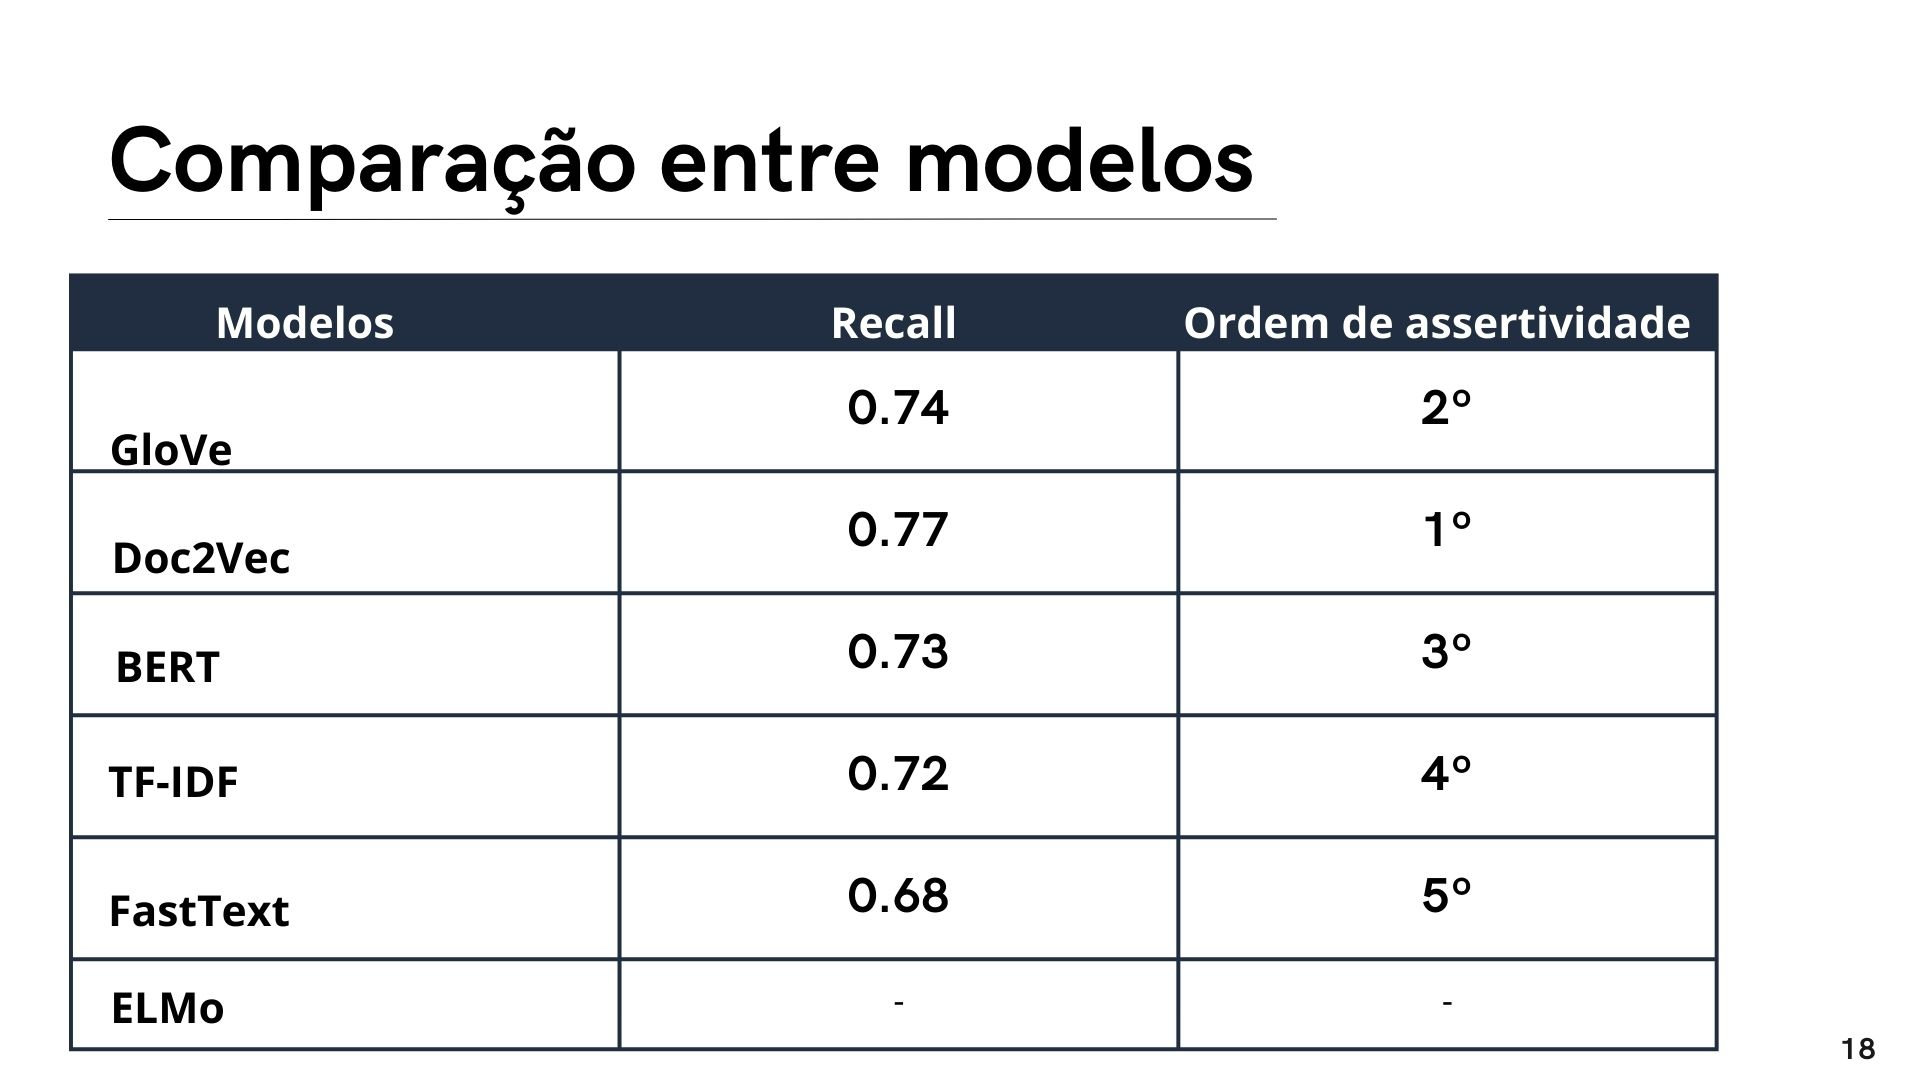

## Melhor resultado da implementação (1ª IMP - 4 dias de teste)

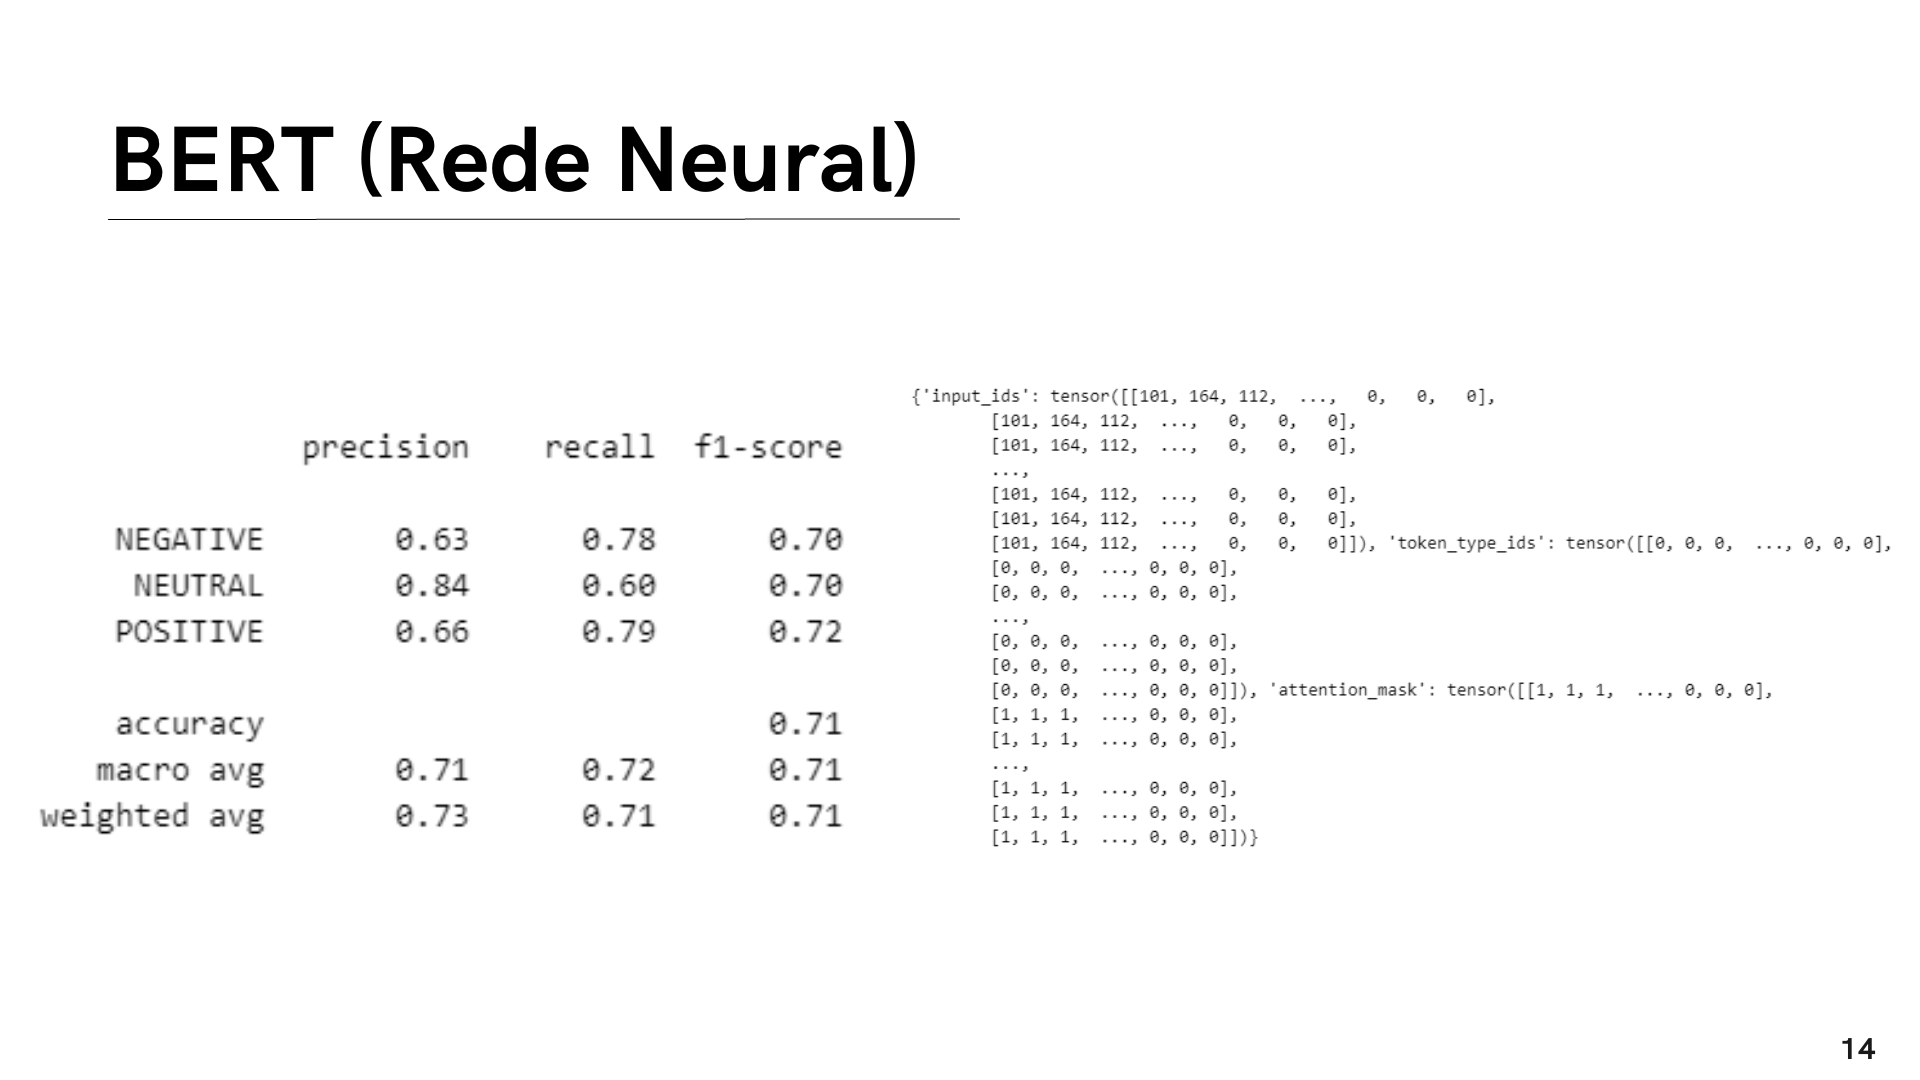